# Predicting the occupancies of Belgian trains

In this lab, we will go over some of the typical steps in a data science pipeline:

* Data processing & cleaning
* Exploratory Data Analysis
* Feature extraction/engineering
* Model selection & hyper-parameter tuning
* Data linking
* ...

We will make use of the following technologies and libraries:

* Python3.5
* Python libraries: pandas, numpy, sklearn, matplotlib, ...
* Kaggle
* **NO SPARK!!!** (next lab will deal with machine learning with Spark MLlib)

In [16]:
%matplotlib inline
%pylab inline
import pandas as pd
import numpy as np
from collections import Counter, OrderedDict
import json
import matplotlib
import matplotlib.pyplot as plt
import re
from scipy.misc import imread
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

Populating the interactive namespace from numpy and matplotlib


## 0. Create a kaggle account! https://www.kaggle.com/

* The competition can be found here: https://inclass.kaggle.com/c/train-occupancy-prediction-v2/leaderboard
* Create an account and form a **team** (shuffle II), use your names and BDS_ as a prefix in your team name
* Note: you can only make 5 submissions per day
* There are also student groups from Kortrijk (Master of Science in Industrial Engineering) participating. They get no help at all (you get this notebook) but this is their final lab + they have no project. **THEREFORE: Let's push them down the leaderboard!!! ;)**  

* **Your deadline:** the end of the kaggle competition. 

* **Evaluation:** Your work will be evaluated for 50%, your result will also matter for another 50%. The top 5 student groups get bonus points for this part of the course!

## 1. Loading and processing the data

Trains can get really crowded sometimes, so wouldn't it be great to know in advance how busy your train will be, so you can take an earlier or later one? iRail, created just that. their application, SpitsGids, shows you the occupancy of every train in Belgium. Furthermore, you can indicate the occupancy yourself. Using the collected data, machine learning models can be trained to predict what the occupancy level of a train will be.

The dataset which we will use during this labo is composed of two files:

* **train.nldjson:** contains labeled training data (JSON records, separated by newlines)
* **test.nldjson:** unlabeled data for which we will create a submission for a Kaggle competition at the end of this lab (again: JSON records, separated by newlines). Each of the records is uniquely identifiable through an id

A json record has the following structure:

```
{
 "querytype": "occupancy",
 "querytime": "2016-09-29T16:24:43+02:00",
 "post": {
     "connection": "http://irail.be/connections/008811601/20160929/S85666",
     "from": "http://irail.be/stations/NMBS/008811601",
     "to": "http://irail.be/stations/NMBS/008811676",
     "date": "20160929",
     "vehicle": "http://irail.be/vehicle/S85666",
     "occupancy": "http://api.irail.be/terms/medium"
 },
 "user_agent": "Railer/1610 CFNetwork/808.0.2 Darwin/16.0.0"
}
```

This is how the five first rows of a processed DataFrame **COULD** look like

![_auto_0](attachment:_auto_0)

** 1.1: ** *Load in both files and store the data in a pandas DataFrame, different methodologies can be applied in order to parse the JSON records ([pd.io.json.json_normalize](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.json.json_normalize.html), [json](https://docs.python.org/3/library/json.html) library, ...)*

In [19]:
from pandas.io.json import json_normalize
import pickle

In [26]:
training_json = pd.DataFrame()
with open('data/training_data.nldjson') as data_file:  
        for line in data_file:
            training_json = training_json.append(json_normalize(json.loads(line)))
with open('data/test.nldjson') as data_file:  
        for line in data_file:
            out_test_json = json_normalize(json.loads(line))

In [754]:
pickle.dump(training_json,open("temp_data/training.pkl","wb"))
pickle.dump(out_test_json,open("temp_data/out_test.pkl","wb"))

In [24]:
#out_test = pickle.load(open("temp_data/out_test.pkl", "rb" ))
#training = pickle.load(open("temp_data/training.pkl", "rb" ))

In [25]:
out_test[0:1]

,id,post.connection,post.date,post.from,post.to,post.vehicle,querytime,querytype,user_agent
0,0,http://irail.be/connections/8892007/20170312/I...,20170312,http://irail.be/stations/NMBS/008892007,http://irail.be/stations/NMBS/008891140,http://irail.be/vehicle/(null),2017-03-12T10:32:59+01:00,occupancy,Railer/1620 CFNetwork/808.3 Darwin/16.3.0


In [27]:
trends_df = pd.DataFrame()

In [28]:
from pytrends.request import TrendReq
import pandas as pd

# enter your own credentials
google_username = "lorenzvanherwaarden@gmail.com"
google_password = "mielcassonadebochnixon628"
#path = ""

# Login to Google. Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq(google_username, google_password, custom_useragent='My Pytrends Script')

for i in range(0,645):
    if i % 5 != 0:
        continue
    try:
        pytrend.build_payload(kw_list=[stations_df[stations_df.destination == i].zoekterm.values[0], stations_df[stations_df.destination == i+1].zoekterm.values[0], stations_df[stations_df.destination == i+2].zoekterm.values[0], stations_df[stations_df.destination == i+3].zoekterm.values[0], stations_df[stations_df.destination == i+4].zoekterm.values[0]],geo="BE",timeframe='2016-07-27 2017-04-05')
        trends_df = pd.concat([trends_df,pytrend.interest_over_time()], axis=1)
    except:
        continue

In [29]:
no_dup_trends = trends_df.T.groupby(level=0).first().T

In [13]:
#training_holidays_druktes = pd.merge(training_holidays_druktes,stations_df[["destination","zoekterm"]], left_on = 'destination', right_on = 'destination')
out_test_holidays_druktes = pd.merge(out_test_holidays_druktes,stations_df[["destination","zoekterm"]], left_on = 'destination', right_on = 'destination')

NameError: name 'out_test_holidays_druktes' is not defined

In [953]:
training_holidays_druktes_copy = training_holidays_druktes
out_test_holidays_druktes_copy = out_test_holidays_druktes

In [958]:
#training_holidays_druktes = training_holidays_druktes_copy
out_test_holidays_druktes = out_test_holidays_druktes_copy

In [14]:
int(no_dup_trends.loc["2016-07-28"]["Brussel trein"])

KeyError: 'the label [2016-07-28] is not in the [index]'

In [955]:
def get_trends(row):
    zoek = str(row.zoekterm_x) 
    datum = str(row["date"])
    try:
        row["trend"] = int(no_dup_trends.loc[datum][zoek])
    except:
        row["trend"] = 0
    return row

In [969]:
#training_holidays_druktes = training_holidays_druktes.apply(get_trends, axis=1)
out_test_holidays_druktes = out_test_holidays_druktes.apply(get_trends, axis=1)

** 1.2: ** *Clean the data! Make sure the station- and vehicle-identifiers are in the right format. A station identifier consists of 9 characters (prefix = '00') and a vehicle identifier consists of the concatentation of the vehicle type (IC/L/S/P/...) and the [line identifier](https://nl.wikipedia.org/wiki/Lijst_van_treincategorie%C3%ABn_in_Belgi%C3%AB). Try to fix as much of the records as possible, drop only the unfixable ones. How many records did you drop?*

In [39]:
training['querytime'] = pd.to_datetime(training['querytime'])
out_test['querytime'] = pd.to_datetime(out_test['querytime'])

training = training.dropna()
training['post.occupancy'] = training['post.occupancy'].apply(lambda x: x.split("http://api.irail.be/terms/",1)[1])

training['post.vehicle'] = training['post.vehicle'].apply(lambda x: x.split("http://irail.be/vehicle/",1)[1])
out_test['post.vehicle'] = out_test['post.vehicle'].apply(lambda x: x.split("http://irail.be/vehicle/",1)[1])
#create class column, eg IC058 -> IC
training['post.class'] = training['post.vehicle'].apply(lambda x: " ".join(re.findall("[a-zA-Z]+", x)))
out_test['post.class'] = out_test['post.vehicle'].apply(lambda x: " ".join(re.findall("[a-zA-Z]+", x)))
#reset the index because you have duplicate indexes now because you appended DFs in a for loop
training = training.reset_index()

In [56]:
stations_df = pd.read_csv('data/stations.csv')
stations_df['from'] = stations_df.index
stations_df['destination'] = stations_df['from']
stations_df[0:4]
#post.from en post.to are in the some format of URI

,URI,name,alternative-fr,alternative-nl,alternative-de,alternative-en,country-code,longitude,latitude,avg_stop_times,from,destination
0,http://irail.be/stations/NMBS/008895000,Aalst,Alost,NaN,NaN,NaN,be,4.039653,50.942813,88.263006,0,0
1,http://irail.be/stations/NMBS/008895125,Aalst-Kerrebroek,NaN,NaN,NaN,NaN,be,4.024407,50.948377,7.297688,1,1
2,http://irail.be/stations/NMBS/008891140,Aalter,NaN,NaN,NaN,NaN,be,3.447848,51.092295,78.488439,2,2
3,http://irail.be/stations/NMBS/008833209,Aarschot,NaN,NaN,NaN,NaN,be,4.824043,50.984406,123.800578,3,3


In [57]:
stations_df["zoekterm"]=stations_df["name"]+" trein"

In [58]:
stations_df.loc[stations_df['zoekterm'].str.startswith("Zaventem"), "zoekterm"] = "Zaventem trein"
stations_df.loc[stations_df['zoekterm'].str.startswith("Brussel"), "zoekterm"] = "Brussel trein"
stations_df.loc[stations_df['zoekterm'].str.startswith("Gent"), "zoekterm"] = "Gent trein"
stations_df.loc[stations_df['zoekterm'].str.startswith("Antwerpen"), "zoekterm"] = "Antwerpen trein"

In [59]:
training_holidays_druktes[0:1]
out_test_holidays_druktes[0:1].destination

NameError: name 'training_holidays_druktes' is not defined

In [60]:
stations_df[0:1]

,URI,name,alternative-fr,alternative-nl,alternative-de,alternative-en,country-code,longitude,latitude,avg_stop_times,from,destination,zoekterm
0,http://irail.be/stations/NMBS/008895000,Aalst,Alost,NaN,NaN,NaN,be,4.039653,50.942813,88.263006,0,0,Aalst trein


In [62]:
druktes_df = pd.read_csv('data/station_druktes.csv')
druktes_df[0:4]

,Unnamed: 0,station,week,zaterdag,zondag,lat,lng,station_link
0,0,AALST,7733,1758,1589,50.942707,4.039143,Aalst
1,1,AALST-KERREBROEK,27,9,9,50.948307,4.024855,Aalst-Kerrebroek
2,2,AALTER,1957,526,536,51.092226,3.449550,Aalter
3,3,AARSCHOT,5660,1414,1104,50.984717,4.824250,Aarschot


In [63]:
training_holidays[0:1]

,index,post.connection,post.date,post.from,post.occupancy,post.to,post.vehicle,querytime,querytype,user_agent,date,post.class,name,school,name_enc,class_enc
0,0,http://irail.be/connections/8813003/20160727/I...,7000,http://irail.be/stations/NMBS/008813003,high,http://irail.be/stations/NMBS/00,IC1518,2016-07-27 18:08:57,occupancy,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,2016-07-27,IC,Summer,1.0,10,4


In [64]:
training = pd.merge(training,stations_df[["URI","from"]], left_on = 'post.from', right_on = 'URI')
training = pd.merge(training,stations_df[["URI","destination"]], left_on = 'post.to', right_on = 'URI')
training = training.drop(['URI_y','URI_x'],1)

In [65]:
out_test = pd.merge(out_test,stations_df[["URI","from"]], left_on = 'post.from', right_on = 'URI')
out_test = pd.merge(out_test,stations_df[["URI","destination"]], left_on = 'post.to', right_on = 'URI')
out_test = out_test.drop(['URI_y','URI_x'],1)

## 2. Exploratory Data Analysis (EDA)

Let's create some visualisations of our data in order to gain some insights. Which features are useful, which ones aren't?

We will create 3 visualisations:
* **Pie chart** of the class distribution
* **Stacked Bar Chart** depicting the distribution for one aggregated variable (such as the weekday or the vehicle type)
* **Scattter plot** depicting the 'crowdiness' of the stations in Belgium

For each of the visualisations, code to generate the plot has already been handed to you. You only need to prepare the data (i.e. create a new dataframe or select certain columns) such that it complies with the input specifications. **If you want to create your own plotting code or extend the given code, you are free to do so!**

** 2.1: ** *Create a pie_chart with the distribution of the different classes. Have a look at our webscraping lab for plotting pie charts. TIP: the value_counts() does most of the work for you!



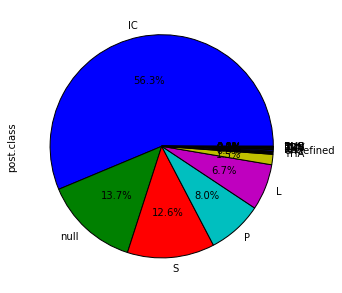

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
training['post.class'].value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%')
#we have a lot of null/undefined, especially in our test set, we can't simply throw them away

** 2.2: ** *Analyze the timestamps in the training and testset. First convert the timestamps to a pandas datetime object using pd.datetime. http://pandas.pydata.org/pandas-docs/stable/timeseries.html

Have the column in this data format simplifies a lot of work, since it allows you to convert and extract time features more easily. For example: 

    - df['weekday] = df['time'].apply(lambda l: l.weekday()) 

would map every date to a day of the week in [0,6]. 

* A. What are the ranges of training and testset, is your challenges one of interpolating or extrapolating in the future? 
**TIP:** The describe() function can already be helpful!


* B. Plot the number of records in both training and testset per day. Have a look here on how to work with the timegrouper functionality: http://stackoverflow.com/questions/15297053/how-can-i-divide-single-values-of-a-dataframe-by-monthly-averages


* C. OPTIONAL: Have insight into the time dependence can get you a long way: Make additional visualizations to make you understand how time affects train occupancy.

In [74]:
training['weekday'] = training['querytime'].apply(lambda l: l.weekday()) 
out_test['weekday'] = out_test['querytime'].apply(lambda l: l.weekday()) 

print(training_holidays_druktes['querytime'].describe())
print(out_test_holidays['querytime'].describe())

date_training = training_holidays_druktes.set_index('querytime')
date_test = out_test_holidays.set_index('querytime')

grouper = pd.TimeGrouper("1d")
date_training = date_training.groupby(grouper).size()
date_test = date_test.groupby(grouper).size()

# plot
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(date_training)
ax.plot(date_test)

NameError: name 'training_holidays_druktes' is not defined

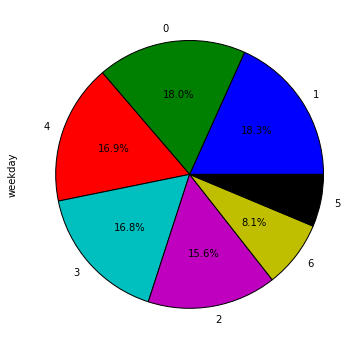

In [942]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
training_holidays_druktes['weekday'].value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%')

In [13]:
training['post.occupancy'].value_counts()

low       2033
high      1566
medium    1451
Name: post.occupancy, dtype: int64

** 2.3: ** *Create a stacked_bar_chart with the distribution of the three classes over an aggregated variable (group the data by weekday, vehicle_type, ...). More info on creating stacked bar charts can be found here: http://pandas.pydata.org/pandas-docs/stable/visualization.html#bar-plots

* The dataframe you need will require your grouping variables as the index, and 1 column occupancy category, for example:

| Index | Occupancy_Low  | Occupancy_Medium | Occupancy_High | Sum_Occupancy |
|-------|----------------|------------------|----------------|---------------|  
| IC    | 15             | 30               | 10             | 55 |
| S     | 20             | 10               | 30             | 60 |
| L     | 12             | 9                | 14             | 35 |

* If you want the values to be relative (%), add a sum column and use it to divide the occupancy columns


** 2.4: ** * To have an idea about the hotspots in the railway network make a scatter plot that depicts the number of visitors per station. Aggregate on the destination station and use the GTFS dataset at iRail to find the geolocation of the stations (stops.txt): https://gtfs.irail.be/nmbs







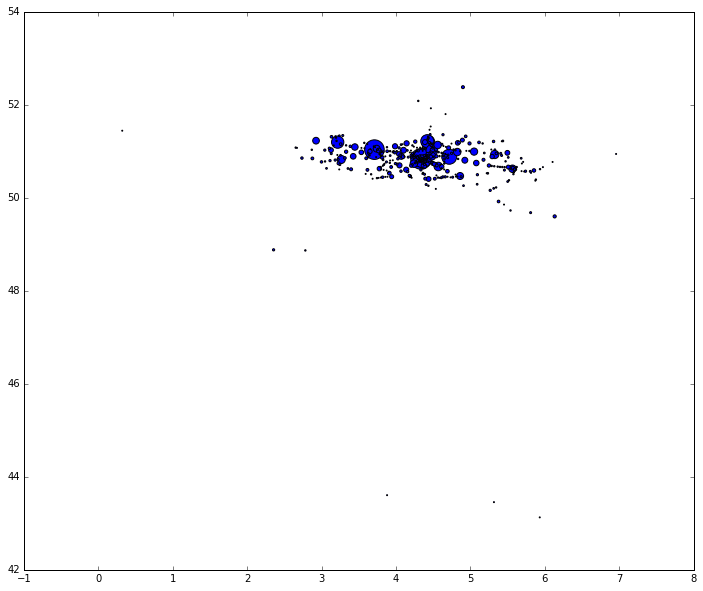

In [943]:
stops = stations_df[['URI','longitude','latitude']] 
dest_count = training_holidays_druktes['post.to'].value_counts()
dest_count_df = pd.DataFrame({'id':dest_count.index, 'count':dest_count.values})
dest_loc = pd.merge(dest_count_df, stops, left_on = 'id', right_on = 'URI')
dest_loc = dest_loc[['id', 'count', 'latitude','longitude']]

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(dest_loc.longitude, dest_loc.latitude, s=dest_loc['count'] )

## 3. Predictive modeling: creating a baseline

Now that we have processed, cleaned and explored our data it is time to create a predictive model that predicts the occupancies of future Belgian trains. We will start with applying Logistic Regression on features extracted from our initial dataset. Some code has already been given to get you started.

### Feature extraction

Some possible features include (bold ones are already implemented for you):

* The day of the week
* **The number of seconds since midnight of the querytime**
* The train vehicle type (IC/P/L/...)
* The line number
* [The line category](https://nl.wikipedia.org/wiki/Lijst_van_treincategorie%C3%ABn_in_Belgi%C3%AB)
* Information about the from- and to-station (their identifier, their coordinates, the number of visitors, ...)
* **The month**
* A binary variable indicating whether a morning (6-10AM) or evening jam (3-7PM) is ongoing
* ...

In order to do reveal relations between these features you can try and plot them with:

* <a href="https://datascience.stackexchange.com/questions/10459/calculation-and-visualization-of-correlation-matrix-with-pandas"> Correlation plot </a>
* <a href="http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-scatter-matrix"> Scatter matrix </a>

These relations can be important since some models do not perform very will when features are highly correlated


### Feature normalization

* Most models require the features to have a similar range, preferables [0,1]. A minmax scaler is usually sufficient: x -> (x - xmin) / (xmax - xmin)

* Scikit will be used quite extensively from now on, have a look here for preprocessing functionality: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

### Dealing with categorical variables

All machine learning techniques, except for tree-based methods, assume that variables are ordinal (you can define an order). For some variables, such as the day of the week or the train vehicle type, this is not true. Therefore, a pre-processing step is required that transforms these categorical variables. A few examples of such transformations are:

* One-hot-encoding (supported by pandas: [get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) )
* Binary encoding: map each variable to a number, binary encode these numbers and use each bit as a feature (advantage of this technique is that it introduces a lot less new variables in contrast to one-hot-encoding)
* Hash encoding
* ...


** 3.1: ** *Extract more features than the two given ones. Make sure you extract at least one categorical variable, and transform it! What gains (in terms of current accuracy (0.417339475755)) do you achieve with new features in comparison to the given code?*

In [635]:
def get_seconds_since_midnight(x):
    midnight = x.replace(hour=0, minute=0, second=0, microsecond=0)
    return (x - midnight).seconds

def get_line_number(x):
    pattern = re.compile("^[A-Z]+([0-9]+)$")
    if pattern.match(x):
        return int(pattern.match(x).group(1))
    else:
        return x
    
training['seconds_since_midnight'] = training['querytime'].apply(get_seconds_since_midnight)
training['month'] = training['querytime'].apply(lambda x: x.month)
training['occupancy'] = training['post.occupancy'].map({'low': 0, 'medium': 1, 'high': 2})

In [636]:
out_test['seconds_since_midnight'] = out_test['querytime'].apply(get_seconds_since_midnight)
out_test['month'] = out_test['querytime'].apply(lambda x: x.month)

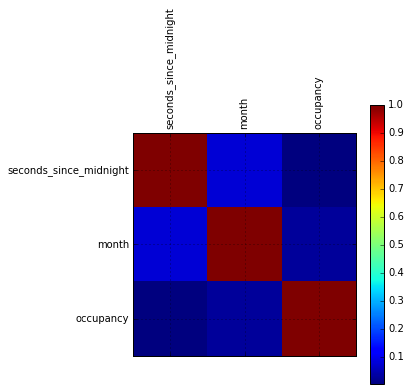

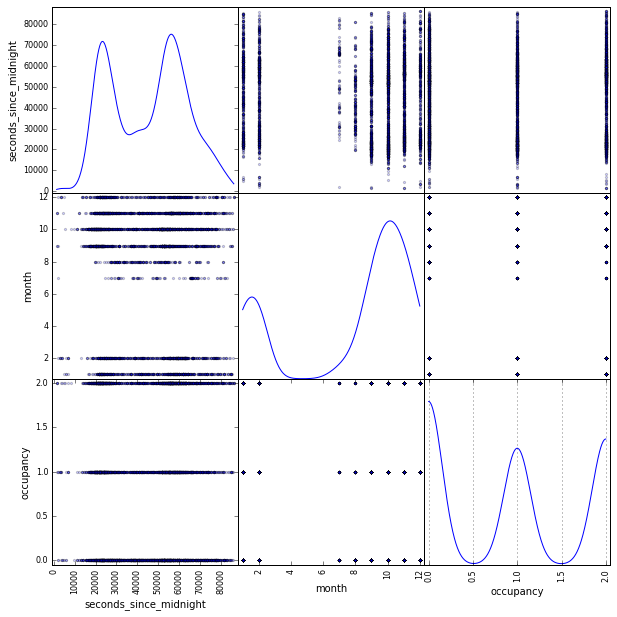

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
corr_frame = training[['seconds_since_midnight', 'month', 'occupancy']].corr()
cax = ax.matshow(abs(corr_frame))
fig.colorbar(cax)
tickpos = np.array(range(0,len(corr_frame.columns)))
plt.xticks(tickpos,corr_frame.columns, rotation='vertical')
plt.yticks(tickpos,corr_frame.columns, rotation='horizontal')
plt.grid(None)

pd.tools.plotting.scatter_matrix(training[['seconds_since_midnight', 'month', 'occupancy']],  
                                 alpha=0.2, diagonal='kde', figsize=(10,10))
plt.grid(None)

* We train our model on a 'training set' and evaluate it on the testset. Functionality for making this split automatically can be found <a href="http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection"> here </a>

* Our first model is a linear logistic regression model, more information on the API <a href="http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model"> here </a>

* The confusion matrix is part of the <a href="http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics"> metrics functionality </a>


In [31]:
skf = StratifiedKFold(n_splits=5, random_state=1337)
X = training[['seconds_since_midnight', 'month']]
y = training['occupancy']
cms = []
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    
    predictions = log_reg.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    cms.append(cm)
    accs.append(accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    #accs.append(sum([float(cm[i][i]) for i in range(len(cm))])/np.sum(cm))
    
print('Confusion matrix:\n', np.mean(cms, axis=0))
print('Avg accuracy', np.mean(accs), '+-', np.std(accs))
print('Predict all lows', float(len(y[y == 0]))/float(len(y)))

             precision    recall  f1-score   support

          0       0.43      0.89      0.58       407
          1       0.00      0.00      0.00       291
          2       0.39      0.20      0.27       314

avg / total       0.29      0.42      0.31      1012

             precision    recall  f1-score   support

          0       0.46      0.81      0.59       407
          1       0.00      0.00      0.00       290
          2       0.35      0.33      0.34       313

avg / total       0.29      0.43      0.34      1010

             precision    recall  f1-score   support

          0       0.44      0.77      0.56       407
          1       0.00      0.00      0.00       290
          2       0.38      0.35      0.36       313

avg / total       0.29      0.42      0.34      1010

             precision    recall  f1-score   support

          0       0.40      1.00      0.57       406
          1       0.00      0.00      0.00       290
          2       0.00      0.00    

/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Since we have a lot of 'Null' (+-1/3th) values for our 'class' feature, and we don't want to throw that away, we can try to predict these labels based on the other features, we get +75% accuracy so that seems sufficient. But we can't forgot to do the same thing for the test set!

In [391]:
training_class = training_holidays[training_holidays.class_enc != 0]
training_class = training_class[training_class.class_enc != 14]
test_class = training_holidays[(training_holidays.class_enc == 0)|(training_holidays.class_enc == 14)]

In [412]:
training_class["class_pred"]=training_class["class_enc"]
training_holidays_enc = pd.concat([training_class,test_class])

In [392]:
X_train = training_class[['seconds_since_midnight','weekday', 'month','id','id_2']]
X_test = test_class[['seconds_since_midnight','weekday', 'month','id','id_2']]
y_train = training_class['class_enc']

In [962]:
train.occupancy.value_counts()/train.shape[0]

0    0.408063
2    0.304818
1    0.287119
Name: occupancy, dtype: float64

In [963]:
test.occupancy.value_counts()/test.shape[0]

0    0.410029
2    0.310718
1    0.279253
Name: occupancy, dtype: float64

In [974]:
out_test_holidays_druktes.occupancy.value_counts()/out_test_holidays_druktes.shape[0]

0    0.752535
2    0.135903
1    0.111562
Name: occupancy, dtype: float64

In [905]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(training_holidays_druktes, test_size=0.2, random_state=42)

In [906]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 

In [907]:
train[0:1]

,index,post.connection,post.date,post.from,post.occupancy,post.to,post.vehicle,querytime,querytype,user_agent,...,drukte_to,day__0,day__1,day__2,day__3,day__4,day__5,day__6,zoekterm_y,trend
4883,0,http://irail.be/connections/8883311/20170225/S...,20170224,http://irail.be/stations/NMBS/008883311,low,http://irail.be/stations/NMBS/008895612,S61584,2017-02-24 19:52:57,occupancy,Railer/1630 CFNetwork/808.3 Darwin/16.3.0,...,466,0,0,0,0,1,0,0,Viane-Moerbeke trein,0


In [994]:
X_train = training_holidays_druktes[['seconds_since_midnight','drukte_from','drukte_to','school','name_enc','class_enc','day__0','day__1','day__2','day__3','day__4','day__5','day__6','from_lat','from_lng','des_lat','des_lng','trend']]
X_test = test[['seconds_since_midnight','drukte_from','drukte_to','school','name_enc','class_enc','day__0','day__1','day__2','day__3','day__4','day__5','day__6','from_lat','from_lng','des_lat','des_lng','trend']]
y_train = training_holidays_druktes['occupancy']
y_test = test['occupancy']
#month uit de set halen als we ongeziene willen predicten

In [456]:
ac = AdaBoostClassifier()
ada_param_grid = {'n_estimators': [10, 30, 100, 300, 1000],
                  'learning_rate': [0.1, 0.3, 1.0, 3.0]}
ac_grid = GridSearchCV(ac,ada_param_grid,cv=3,
                       scoring='accuracy')
ac_grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 30, 100, 300, 1000], 'learning_rate': [0.1, 0.3, 1.0, 3.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [929]:
ac = ac_grid.best_estimator_
ac.fit(X_train, y_train)
print(ac_grid.score(X_train,y_train))
print(ac_grid.score(X_test, y_test))

0.524090462144
0.470993117011


In [450]:
from scipy.stats import randint as sp_randint
param_dist = {"max_depth": [7,6, None],
              "max_features": range(1, 5),
              "min_samples_split": range(2, 7),
              "min_samples_leaf": range(1, 7),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
rand = GridSearchCV(rf,param_dist,cv=3,
                       scoring='accuracy')
rand.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [7, 6, None], 'criterion': ['gini', 'entropy'], 'max_features': range(1, 5), 'min_samples_split': range(2, 7), 'min_samples_leaf': range(1, 7), 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [987]:
rf = rand.best_estimator_
rf.fit(X_train, y_train)
print(rf.score(X_train,y_train))
print(rf.score(X_test, y_test))

0.988446411013
0.527040314651


In [931]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
print(dtc.score(X_train,y_train))
print(dtc.score(X_test, y_test))

0.999508357915
0.487708947886


In [932]:
rf2 = rand.best_estimator_
rf3 = rand.best_estimator_
rf4 = rand.best_estimator_

In [995]:
voting_clf = VotingClassifier(
estimators=[('ac', ac), ('rf', rf), ('dtc', dtc),('rf2', rf2), ('rf3', rf3), ('rf4', rf4)],
voting='hard'
)

In [996]:
from sklearn.metrics import accuracy_score
for clf in (ac, rf, dtc, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

AdaBoostClassifier 0.520157325467
RandomForestClassifier 0.985250737463
DecisionTreeClassifier 1.0
VotingClassifier 0.988200589971


In [981]:
pd.DataFrame([X_train.columns, rf.feature_importances_])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,seconds_since_midnight,drukte_from,drukte_to,school,name_enc,class_enc,day__0,day__1,day__2,day__3,day__4,day__5,day__6,from_lat,from_lng,des_lat,des_lng,trend
1,0.212076,0.0949629,0.0883931,0.00858929,0.0223553,0.0507817,0.0131651,0.0149866,0.0108507,0.0161451,0.0179376,0.00792163,0.00947647,0.0953628,0.0828508,0.0948085,0.0811075,0.0782284


In [998]:
y_predict_test = voting_clf.predict(out_test_holidays_druktes[['seconds_since_midnight','drukte_from','drukte_to','school','name_enc','class_enc','day__0','day__1','day__2','day__3','day__4','day__5','day__6','from_lat','from_lng','des_lat','des_lng','trend']])

In [999]:
out_test_holidays_druktes["occupancy"] = y_predict_test

In [1000]:
out_test_holidays_druktes.occupancy.value_counts()/out_test_holidays_druktes.shape[0]

0    0.736308
1    0.135903
2    0.127789
Name: occupancy, dtype: float64

In [1005]:
out_test_holidays_druktes[['seconds_since_midnight','drukte_from','drukte_to','name_enc','class_enc','day__0','day__1','day__2','day__3','day__4','day__5','day__6','trend','occupancy']][0:100]

,seconds_since_midnight,drukte_from,drukte_to,name_enc,class_enc,day__0,day__1,day__2,day__3,day__4,day__5,day__6,trend,occupancy
0,34379,22046,536,0,8,0,0,0,0,0,0,1,0,0
1,55488,55817,1957,0,1,0,0,1,0,0,0,0,0,0
2,48917,55817,1957,0,8,1,0,0,0,0,0,0,0,0
3,78560,22046,12782,0,8,0,0,0,0,0,0,1,0,0
4,48985,21184,11409,0,1,0,0,0,0,0,1,0,36,0
5,70303,55817,18095,0,3,0,0,1,0,0,0,0,24,0
6,36627,55817,18095,0,1,0,0,1,0,0,0,0,12,0
7,70687,55817,18095,0,1,0,0,1,0,0,0,0,12,0
8,49638,62545,18095,0,1,0,1,0,0,0,0,0,0,0
9,68145,7330,18095,0,8,0,0,0,0,1,0,0,13,0


In [1001]:
out_test_holidays_druktes[["id","occupancy"]].to_csv('predictions.csv',index=False)

## 4. 'Advanced' predictive modeling: model selection & hyper-parameter tuning

### Model evaluation and hyper-parameter tuning

In order to evaluate your model, K-fold cross-validation (`https://en.wikipedia.org/wiki/Cross-validation_(statistics)` ) is often applied. Here, the data is divided in K chunks, K-1 chunks are used for training while 1 chunk is used for testing. Different metrics exist, such as accuracy, AUC, F1 score, and more. For this lab, we will use accuracy.

Some machine learning techniques, supported by sklearn:

* SVMs
* Decision Trees
* Decision Tree Ensemble: AdaBoost, Random Forest, Gradient Boosting
* Multi-Level Perceptrons/Neural Networks
* Naive Bayes
* K-Nearest Neighbor
* ...


To tune the different hyper-parameters of a machine learning model, again different techniques exist:
* [Grid search](http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html): exhaustively try all possible parameter combinations (**Code to tune the different parameters of our LogReg model has been given**)
* [Random search](http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html#sphx-glr-auto-examples-model-selection-randomized-search-py): try a number of random combinations, it has been [shown](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) that this is quite equivalent to grid search

** 4.1: ** *Choose one or more machine learning techniques, different from Logistic Regression and apply them to our data, with tuned hyper-parameters! You will see that switching techniques in sklearn is really simple! Which model performs best on this data? *

In [35]:
skf = StratifiedKFold(n_splits=5, random_state=1337)
X = training[['seconds_since_midnight', 'month']]
y = training['occupancy']
cms = []
accs = []
parameters = {#'penalty': ['l1', 'l2'],  # No penalty tuning, cause 'l1' is only supported by liblinear
              # It can be interesting to manually take a look at 'l1' with 'liblinear', since LASSO
              # provides sparse solutions (boils down to the fact that LASSO does some feature selection for you)
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
              'tol': [1e-4, 1e-6, 1e-8], 
              'C': [1e-2, 1e-1, 1.0, 1e1],
              'max_iter': [1e2, 1e3]
             }
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    tuned_log_reg = GridSearchCV(LogisticRegression(penalty='l2'), parameters, cv=3,
                       scoring='accuracy')
    tuned_log_reg.fit(X_train, y_train)
    print(tuned_log_reg.best_params_)
    
    predictions = tuned_log_reg.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    cms.append(cm)
    accs.append(accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    
print('Confusion matrix:\n', np.mean(cms, axis=0))
print('Avg accuracy', np.mean(accs), '+-', np.std(accs))
print('Predict all lows', float(len(y[y == 0]))/float(len(y)))

/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: Th

{'max_iter': 100.0, 'tol': 0.0001, 'solver': 'lbfgs', 'C': 0.01}
             precision    recall  f1-score   support

          0       0.40      1.00      0.57       407
          1       0.00      0.00      0.00       291
          2       0.00      0.00      0.00       314

avg / total       0.16      0.40      0.23      1012



/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/l

{'max_iter': 100.0, 'tol': 1e-08, 'solver': 'liblinear', 'C': 0.1}
             precision    recall  f1-score   support

          0       0.40      1.00      0.57       407
          1       0.00      0.00      0.00       290
          2       0.00      0.00      0.00       313

avg / total       0.16      0.40      0.23      1010



/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/l

{'max_iter': 100.0, 'tol': 1e-06, 'solver': 'liblinear', 'C': 0.01}
             precision    recall  f1-score   support

          0       0.40      1.00      0.57       407
          1       0.00      0.00      0.00       290
          2       0.00      0.00      0.00       313

avg / total       0.16      0.40      0.23      1010



/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/l

{'max_iter': 100.0, 'tol': 0.0001, 'solver': 'liblinear', 'C': 0.01}
             precision    recall  f1-score   support

          0       0.40      1.00      0.57       406
          1       0.00      0.00      0.00       290
          2       0.00      0.00      0.00       313

avg / total       0.16      0.40      0.23      1009



/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/scipy/optimize/l

{'max_iter': 100.0, 'tol': 0.0001, 'solver': 'liblinear', 'C': 0.01}
             precision    recall  f1-score   support

          0       0.40      0.99      0.57       406
          1       0.00      0.00      0.00       290
          2       0.12      0.00      0.01       313

avg / total       0.20      0.40      0.23      1009

Confusion matrix:
 [[  4.05800000e+02   2.00000000e-01   6.00000000e-01]
 [  2.89400000e+02   0.00000000e+00   8.00000000e-01]
 [  3.12400000e+02   6.00000000e-01   2.00000000e-01]]
Avg accuracy 0.401979886574 +- 0.000858470013782
Predict all lows 0.4025742574257426


/Users/davidsmolders/Downloads/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 5. Data augmentation with external data sources

There is a unlimited amount of factors that influence the occupancy of a train! Definitely more than the limited amount of data given in the feedback logs. Therefore, we will try to create new features for our dataset using external data sources. Examples of data sources include:

* Weather APIs
* A holiday calendar
* Event calendars
* Connection and delay information of the SpitsGidsAPI
* Data from the NMBS/SNCB
* Twitter and other social media
* many, many more

In order to save time, a few 'prepared' files have already been given to you. Of course, you are free to scrape/generate your own data as well:

* Hourly weather data for all stations in Belgium, from August till April `weather_data.zip`
* A file which contains the vehicle identifiers and the stations where this vehicle stops  `line_info.csv`
* Based on this line_info, you can construct a graph of the rail net in Belgium and apply some fancy graph features (pagerank, edge betweenness, ...) `iGraph experiments.ipynb`
* A file containing the coordinates of a station, and the [number of visitors during week/weekend for 2015](http://www.belgianrail.be/nl/~/media/8F764D77F60F48B188A8742652C6E48F.ashx)  `station_druktes.csv`
* A file with some of the holidays (this can definitely be extended) `holidays.json`
* For event data, there is the [Eventful API](api.eventful.com)

** 5.1: ** *Pick one (or more) external data source(s) and link your current data frame to that data source (requires some creativity in most cases). Extract features from your new, linked data source and re-train your model. How much gain did you achieve?*

Als we kijken naar "training.id.value_counts()" dan zien we vooral dat het om studenten bestemmingen gaat, misschien komt dat omdat het vooral hen zijn die deze app gebruiken? We moeten dus nadenken wanneer zij de trein nemen, en wat dat kan beinvloeden. Misschien het aantal studenten per station incorporeren?

In [31]:
holiday_pops = pd.read_json('data/holidays.json')
holidays = pd.read_json( (holiday_pops['holidays']).to_json(), orient='index')

In [32]:
holidays['date'] = pd.to_datetime(holidays['date'])
holidays.head(1)

,date,name,school
0,2016-01-01,Nieuwjaar,0


In [33]:
training["date"] = training["querytime"].values.astype('datetime64[D]')
out_test["date"] = out_test["querytime"].values.astype('datetime64[D]')

/Users/lorenzvanherwaarden/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if __name__ == '__main__':
/Users/lorenzvanherwaarden/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  from ipykernel import kernelapp as app


In [75]:
training_holidays = pd.merge(training,holidays, how="left", on='date')
training_holidays.school = training_holidays.school.fillna(0)
training_holidays.name = training_holidays.name.fillna("geen")
training_holidays[0:1]

,index,post.connection,post.date,post.from,post.occupancy,post.to,post.vehicle,querytime,querytype,user_agent,date,post.class,from,destination,weekday,name,school
0,0,http://irail.be/connections/8813003/20160728/I...,20160728,http://irail.be/stations/NMBS/008813003,medium,http://irail.be/stations/NMBS/008892007,IC1538,2016-07-28 14:44:52,occupancy,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,2016-07-28,IC,89,202,3,Summer,1.0


In [76]:
out_test_holidays = pd.merge(out_test,holidays, how="left", on='date')
out_test_holidays.school = out_test_holidays.school.fillna(0)
out_test_holidays.name = out_test_holidays.name.fillna("geen")
out_test_holidays[0:1]

,id,post.connection,post.date,post.from,post.to,post.vehicle,querytime,querytype,user_agent,date,post.class,from,destination,weekday,name,school
0,0,http://irail.be/connections/8892007/20170312/I...,20170312,http://irail.be/stations/NMBS/008892007,http://irail.be/stations/NMBS/008891140,(null),2017-03-12 09:32:59,occupancy,Railer/1620 CFNetwork/808.3 Darwin/16.3.0,2017-03-12,null,202,2,6,geen,0.0


In [77]:
out_test_holidays.sort('date')

/Users/lorenzvanherwaarden/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,id,post.connection,post.date,post.from,post.to,post.vehicle,querytime,querytype,user_agent,date,post.class,from,destination,weekday,name,school
290,52,http://irail.be/connections/8833001/20170301/L...,20170301,http://irail.be/stations/NMBS/008833001,http://irail.be/stations/NMBS/008833209,L2884,2017-03-01 11:56:26,occupancy,Railer/1630 CFNetwork/808.3 Darwin/16.3.0,2017-03-01,L,312,3,2,geen,0.0
27,53,http://irail.be/connections/8813003/20170301/I...,20170301,http://irail.be/stations/NMBS/008813003,http://irail.be/stations/NMBS/008814001,(null),2017-03-01 15:49:20,occupancy,Railer/1630 CFNetwork/808.2.16 Darwin/16.3.0,2017-03-01,null,89,97,2,geen,0.0
261,46,http://irail.be/connections/8811148/20170301/S...,20170301,http://irail.be/stations/NMBS/008811148,http://irail.be/stations/NMBS/008811007,(null),2017-03-01 08:32:18,occupancy,Railer/1630 CFNetwork/808.3 Darwin/16.3.0,2017-03-01,null,98,450,2,geen,0.0
25,45,http://irail.be/connections/8883311/20170301/S...,20170301,http://irail.be/stations/NMBS/008883311,http://irail.be/stations/NMBS/008814001,S61556,2017-03-01 07:03:18,occupancy,Railer/1630 CFNetwork/808.2.16 Darwin/16.3.0,2017-03-01,S,147,97,2,geen,0.0
403,60,http://irail.be/connections/8886009/20170301/I...,20170301,http://irail.be/stations/NMBS/008886009,http://irail.be/stations/NMBS/008886348,(null),2017-03-01 17:50:36,occupancy,Railer/1630 CFNetwork/808.3 Darwin/16.3.0,2017-03-01,null,28,313,2,geen,0.0
22,59,http://irail.be/connections/8831401/20170301/I...,20170301,http://irail.be/stations/NMBS/008831401,http://irail.be/stations/NMBS/008814001,IC2240,2017-03-01 17:42:55,occupancy,Railer/1630 CFNetwork/808.3 Darwin/16.3.0,2017-03-01,IC,136,97,2,geen,0.0
348,41,http://irail.be/connections/8812062/20170301/S...,20170301,http://irail.be/stations/NMBS/008812062,http://irail.be/stations/NMBS/008812047,(null),2017-03-01 05:47:11,occupancy,Railer/1630 CFNetwork/808.3 Darwin/16.3.0,2017-03-01,null,548,277,2,geen,0.0
331,44,http://irail.be/connections/8821006/20170301/T...,20170301,http://irail.be/stations/NMBS/008821006,http://irail.be/stations/NMBS/008727100,THA9310,2017-03-01 06:19:05,occupancy,Railer/1630 CFNetwork/808.3 Darwin/16.3.0,2017-03-01,THA,16,592,2,geen,0.0
387,58,http://irail.be/connections/8861200/20170301/I...,20170301,http://irail.be/stations/NMBS/008861200,http://irail.be/stations/NMBS/008811601,(null),2017-03-01 17:18:03,occupancy,Railer/1630 CFNetwork/808.3 Darwin/16.3.0,2017-03-01,null,197,410,2,geen,0.0
386,57,http://irail.be/connections/8821535/20170301/I...,20170301,http://irail.be/stations/NMBS/008821535,http://irail.be/stations/NMBS/008821071,(null),2017-03-01 17:16:20,occupancy,Railer/1630 CFNetwork/808.3 Darwin/16.3.0,2017-03-01,null,282,152,2,geen,0.0


In [78]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
#encode the names from the holidays (Summer,Christmas...)
training_holidays["name_enc"] = encoder.fit_transform(training_holidays["name"])
out_test_holidays["name_enc"] = encoder.fit_transform(out_test_holidays["name"])
#encode the classes (IC,TGV,L...)
training_holidays["class_enc"] = encoder.fit_transform(training_holidays["post.class"])
out_test_holidays["class_enc"] = encoder.fit_transform(out_test_holidays["post.class"])

In [79]:
training_holidays=training_holidays.rename(columns = {'too':'destination'})
out_test_holidays=out_test_holidays.rename(columns = {'too':'destination'})

In [80]:
stations_df[0:1]

,URI,name,alternative-fr,alternative-nl,alternative-de,alternative-en,country-code,longitude,latitude,avg_stop_times,from,destination,zoekterm
0,http://irail.be/stations/NMBS/008895000,Aalst,Alost,NaN,NaN,NaN,be,4.039653,50.942813,88.263006,0,0,Aalst trein


Transform all null classes to one null class, maybe try to predict the class? Based on to and from and time

In [81]:
def transform_druktes(row):
    start = row['from']
    destination = row['destination']
    day = row['weekday']
    row['from_lat']=stations_df[stations_df["from"] == start]["latitude"].values[0]
    row['from_lng']=stations_df[stations_df["destination"] == destination]["longitude"].values[0]
    row['des_lat']=stations_df[stations_df["from"] == start]["latitude"].values[0]
    row['des_lng']=stations_df[stations_df["destination"] == destination]["longitude"].values[0]
    row['zoekterm']=stations_df[stations_df["destination"] == destination]["zoekterm"].values[0]
    if day == 5:
        row['drukte_from']=stations_df[stations_df["from"] == start]["zaterdag"].values[0]
        row['drukte_to']=stations_df[stations_df["destination"] == destination]["zaterdag"].values[0]
    elif day == 6:
        row['drukte_from']=stations_df[stations_df["from"] == start]["zondag"].values[0]
        row['drukte_to']=stations_df[stations_df["destination"] == destination]["zondag"].values[0]
    else:
        row['drukte_from']=stations_df[stations_df["from"] == start]["week"].values[0]
        row['drukte_to']=stations_df[stations_df["destination"] == destination]["week"].values[0]
    
    return row

In [82]:
training_holidays_druktes = training_holidays.apply(transform_druktes, axis=1)
out_test_holidays_druktes = out_test_holidays.apply(transform_druktes, axis=1)

KeyError: ('week', 'occurred at index 0')

In [54]:
training_holidays_druktes = pd.concat([training_holidays_druktes,
           pd.get_dummies(training_holidays_druktes['weekday'], prefix="day_"), 
           ],1)
out_test_holidays_druktes = pd.concat([out_test_holidays_druktes,
           pd.get_dummies(out_test_holidays_druktes['weekday'], prefix="day_"), 
           ],1)

NameError: name 'training_holidays_druktes' is not defined

## 6. Generating a Kaggle submission and comparing your methodology to others

** 6.1: ** *Train your best performing model on `train.nldjson` and generate predictions for `test.nldjson`. Create a file called `submission.csv` with format listed below and submit it on the [Kaggle competition](https://inclass.kaggle.com/c/train-occupancy-prediction-v2)! What's your position on the leaderboard?*

## For the interested


** Blog posts **

https://medium.com/@nathan.gs/predicting-occupancy-on-the-belgian-railroads-based-on-spitsgids-irail-data-using-azure-ml-95aa89f22620#.j4d3jeb8y

https://dataminded.be/blog/predicting-occupancy-nmbs-trains

https://medium.com/@gillesvandewiele/predicting-the-occupancy-of-nmbs-trains-using-logs-from-spitsgids-app-v1-0-82b2bcff9bd2#.8pr5m07uq


** LocWeb2017 paper **

[Gilles Vandewiele, Pieter Colpaert, Olivier Janssens, Joachim Van Herwegen, Ruben Verborgh, Erik Mannens, Femke Ongenae, and Filip De Turck. "Predicting Train Occupancies based on Query Logs and External Data Sources." In Proceedings of the 26th International Conference on World Wide Web Companion, pp. 1469-1474. International World Wide Web Conferences Steering Committee, 2017.](http://dl.acm.org/citation.cfm?id=3051699)


** Kaggle **

If you are still interested and think you can improve your model even more: feel free to compete in the [public Kaggle competition](https://inclass.kaggle.com/c/train-occupancy-prediction/) (**NOTE:** make sure you use the training and test data from that competition (smaller dataset)) till the end of it! Can you become the new #1? 


## You can always contact me on gilles.vandewiele (at) ugent (dot) be if you want to discuss your methodology or if you want more details about my methodology! 

